In [1]:
from pyNBS import data_import_tools as dit
from pyNBS import network_propagation as prop
from pyNBS import pyNBS_core as core
from pyNBS import pyNBS_single
from pyNBS import consensus_clustering as cc
from pyNBS import pyNBS_plotting as plot
from sklearn.metrics.cluster import adjusted_mutual_info_score, adjusted_rand_score
import time
import networkx as nx
import pandas as pd
import numpy as np
from IPython.display import Image

## Running Parameters

|Param|Help|
|:------|:------|
|verbose|Verbosity flag for reporting on patient similarity network construction steps.|
|sm_data_file|Path to binary mutation matrix file. May be a csv or 2-column list where each line is a sample and the gene mutated separated by a common delimiter.|
|network_path|Path to molecular network file. File must be table where each line is a gene interaction separated by a common delimiter and the first 2 columns represent interacting proteins.|
|mut_filetype|File structure of binary mutation data. 2 options: "matrix" (e.g. csv or tsv) or "list" (2-column list). Typically reading a "list" is faster.|
|mut_filedelim|Delimiter used in binary mutation file. Default is tab white space.|
|net_filedelim|Delimiter used in network file between columns. Default is tab white space.|
|degree_preserved_shuffle|Determination of whether or not to shuffle the network edges (while preserving node degree) when loading network.|
|node_label_shuffle|Determination of whether or not to shuffle the network node labels (while preserving network topology) when loading network.|
|reg_net_gamma|Value of adjustment on propagation network graph laplacian to calculate influence matrix for (via Vandin 2011).|
|k_nearest_neighbors|Number of nearest neighbors to add to the regularization network during construction.|
|save_knn_glap|File path of where to save graph laplacian for k-nearest-neighbor network constructed from propagation network influence matrix. No path given as default, automatically saves pandas hdf file if file path given.|
|niter|Number of iterations to perform sub-sampling and network-regularized NMF before consensus clustering.|
|save_H|File path of where to save decomposed patient profiles. No path given as default, automatically saves csv file if file path given.|
|consensus_cluster|Determination of whether or not to perform consensus clustering on decompositions of patient profiles.|
|assign_clusters|Determination of whether or not to assign numerical clusters to patients based on consensus clustering of patient profiles.|
|save_co_cluster_matrix|File path of where to save patient co-clustering matrix. No path given as default, automatically saves csv file if file path given.|
|save_cluster_assignments|File path of where to save patient cluster assignments. No path given as default, automatically saves csv file if file path given.|
|plot_co_cluster_map|Determination of whether or not to plot the co-clustering matrix. Requires consensus clustering and cluster assignments.|
|plot_title|Title of co-clustering matrix map if desired.|
|save_co_cluster_map|File path of where to save co-clustering matrix plot. No path given as default, automatically saves pdf file if file path given.|
|save_km_plot|File path of where to save Kaplan-Meier plot. No path given as default, automatically saves pdf file if file path given.|


In [2]:
run_pyNBS_params = {'verbose' : True,
                    
                    ##### Path for HNSC #####
                    # Data used in this notebook is located in /data folder in the repository.
                    # To run this notebook, please modify the path to indicate your local directory.
                    # If you would like to use your own data file, 
                    # please refer to the "Load data" cell below for formatting details.
                     
                    # Please make sure you modify file path for loading/saving to indicate your local directory                 
                    'sm_data_file' : '~/pyNBS/data/Mutation_Files/HNSC_sm_data.txt',
                    'network_path' : '~/pyNBS/data/Network_Files/CancerSubnetwork.txt',
                    
                    'mut_filetype' : 'list',
                    'mut_filedelim' : '\t',
                    'net_filedelim' : '\t',
                    'degree_preserved_shuffle' : False,
                    'node_label_shuffle' : False,

                    'reg_net_gamma' : 0.01,
                    'k_nearest_neighbors' : 11,
                    'save_knn_glap' : None,
                    'niter' : 100, 

                    'save_H' : None,
                    'consensus_cluster' : True,
                    'assign_clusters' : True,
                    'save_co_cluster_matrix' : '~/pyNBS/Example_Notebooks/notebook_results/HNSC/HNSC_co_cluster_matrix.csv',
                    'save_cluster_assignments' : '~/pyNBS/Example_Notebooks/notebook_results/HNSC/HNSC_cluster_assignment.csv',
                    'plot_co_cluster_map' : True,
                    'plot_title' : 'HNSC Consensus Cluster Map',
                    'save_co_cluster_map' : '~/pyNBS/Example_Notebooks/notebook_results/HNSC/HNSC_co_cluster.png',
                    'save_km_plot' : '~/pyNBS/Example_Notebooks/notebook_results/HNSC/HNSC_KM_plot.png'
                    }

## NBS Options

|Option|Type|Default|Help|
|:------|:------|:------|:------|
|pats_subsample_p|float|0.8|Proportion of samples to sub-sample|
|gene_subsample_p|float|0.8|Proportion of mutated genes to sub-sample|
|min_muts|positive_int|10|Minimum number of mutations for a sample to contain after sub-sampling to be considered for further analysis|
|prop_data|bool|True|Determination of whether or not to propagate sub-sampled binary mutation data over given molecular network 
|prop_alpha  |restricted_float|0.7|Propagation constant to use in the propagation of mutations over molecular network. Range is 0.0-1.0 exclusive. |
|prop_symmetric_norm|bool|False|Network degree normalization method for random walk-propagation. |
|qnorm_data  |bool  |True |Determination of whether or not to qunatile normalize mutation profiles. |
|netNMF_k  |positive_int  |4 |Number of components to decompose patient mutation data into. Same as the number of clusters of patients to separate data into. |
|netNMF_gamma  |positive_int  |200 |Regularization constant to scale network regularization term in netNMF. 
|netNMF_niter  |positive_int  |250 |Maximum umber of multiplicative updates to perform within network-regularized NMF if result does not converge. |
|netNMF_eps  |float  |1e-15  |Epsilon error value to adjust 0 values during multiplicative matrix updates in netNMF |
|netNMF_err_tol  |float  |1e-4  |Minimum error tolerance for matrix reconstruction of original data for convergence. |
|netNMF_err_delta_tol  |float  |1e-4  |Minimum error tolerance for l2 norm of difference in matrix reconstructions between iterations of netNMF for convergence. |

In [3]:
NBS_options = {'pats_subsample_p' : 0.8, 
               'gene_subsample_p' : 0.8, 
               'min_muts' : 10,
               'prop_data' : True, 
               'prop_alpha' : 0.7, 
               'prop_symmetric_norm' : False, 
               'qnorm_data' : True,
               'netNMF_k' : 4, 
               'netNMF_gamma' : 200, 
               'netNMF_niter' : 250, 
               'netNMF_eps' : 1e-15, 
               'netNMF_err_tol' : 1e-4, 
               'netNMF_err_delta_tol' : 1e-8}

## Load data

Somatic mutation data and network are __required__ to run pyNBS. 
>__Somatic mutation data__ can be of two filetypes: __matrix__ or __list__
>>A __matrix__ is a binary csv or tsv matrix with rows represent samples/patients and columns represent genes. <br>
Following table is an example of the somatic mutation data format:

||A1CF|A2BP1|A2M|
|-|-|-|-|
|TCGA-04-1638|0|0|1|
|TCGA-23-1029|1|0|0|
|TCGA-23-2647|0|1|0|
|TCGA-24-1847|0|0|1|
|TCGA-42-2589|1|0|0|


>> A __list__ is a 2 column text file separeated by delimeter where 1st column is sample/patient, 2nd column is one gene mutated in that patient. 
The following chart is an example of a list file:

|Patient ID|Gene mutated|
|-|-|
|TCGA-04-1638|A2M|
|TCGA-23-1029|A1CF|
|TCGA-23-2647|A2BP1|
|TCGA-24-1847|A2M|
|TCGA-42-2589|A1CF|
>__Network file__ is a unweighted network. The default delimiter is tab, yet it can be set by user. Only the first two colcumns are read as edges for the network, all other columns will be ignored. There are also options to shuffle the network by preserving node-degree or by permuting network node labels


In [4]:
# Load somatic mutation data
sm_mat = dit.load_binary_mutation_data(run_pyNBS_params['sm_data_file'], filetype=run_pyNBS_params['mut_filetype'], delimiter=run_pyNBS_params['mut_filedelim'], verbose=run_pyNBS_params['verbose'])
# Load network
network = dit.load_network_file(run_pyNBS_params['network_path'], delimiter=run_pyNBS_params['net_filedelim'], degree_shuffle=run_pyNBS_params['degree_preserved_shuffle'], 
                                label_shuffle=run_pyNBS_params['node_label_shuffle'], verbose=run_pyNBS_params['verbose'])


Binary Mutation Matrix Loaded: /cellar/users/t1jia/pyNBS/data/Mutation_Files/HNSC_sm_data.txt
Network File Loaded: /cellar/users/t1jia/pyNBS/data/Network_Files/CancerSubnetwork.txt


## KNN Graph Laplacian

Construct or load the pre-constructed KNN regularization network graph laplacian. <br> __Parameters and options:__ <br>

|Parameter|Name in run_pyNBS_params|Default value|Description|
|:-|:-|:-|:-|
|$\gamma$|reg_net_gamma|0.01|The diagnal correction value suggested in Vandin 2011*|
|$k_n$|k_nearest_neighbors|11|The number of nearest neighbors to construct network regularizer from|

__Steps to construct knnGlap:__
> 1. Construct network laplacian matrix
> 2. Adjust diagonal of laplacian matrix by small gamma as seen in Vandin 2011*
> 3. Calculate the inverse of diagonal adjusted graph laplacian to get graph influence matrix (Vandin 2011*) <br> _This method is significantly faster than the method proposed previously in NBS v0.2.0 to calculate the pseudoinverse of each network component._
> 4. Construct KNN graph using the 11 nearest neighbors by influence score
> 5. Save to the given path

---
* Fabio Vandin, Eli Upfal, and Benjamin J. Raphael. Journal of Computational Biology. March 2011, 18(3): 507-522. https://doi.org/10.1089/cmb.2010.0265

In [5]:
# Get knnGlap
knnGlap = core.network_inf_KNN_glap(network, gamma=run_pyNBS_params['reg_net_gamma'], kn=run_pyNBS_params['k_nearest_neighbors'], verbose=run_pyNBS_params['verbose'], save_path=run_pyNBS_params['save_knn_glap'])

Graph influence matrix calculated: 1.99837589264 seconds
Graph laplacian of KNN network from influence matrix calculated: 4.86287593842 seconds


## Network propagation kernel

Construct or load the pre-constructed network propagation kernel.<br>
Implementation is based on the closed form of the random walk model over networks presented by the HotNet2* paper.<br>

__Parameters and options: __

|Parameters/Option|Name in run_pyNBS_params|Default|Description|Note|
|:-|:-|:-|:-|:-|
|$$\alpha$$|prop_alpha|0.7|Propagation constant to use in the propagation of mutations over molecular network. Range is 0.0-1.0 exclusive.|0.7 is used in Hofree paper; further tunning can be done for potentially better result|
|symmetric_norm|prop_symmetric_norm|False|Network degree normalization method for random walk-propagation|Symetric norm is used in UCEC task in Hofree paper|

__Steps for network propagation:__
> 1. Separate network into connected components and calculate propagation values of each sub-sample on each connected component
> 2. Random walk propagation on all sub-graphs.<br>
Closed form random-walk propagation for each subgraph is given by: <br>
$$F_t = (1-\alpha)*F_o*(I-\alpha*A)^{-1}$$<br>
Let A be the adjcency matrix, D be the diagonalized degree sum of adjacency matrix A. <br>If symmetric norm is used, then the adjacency matrix is normalized as $D^{-0.5} * A * D^{-0.5}$; Otherwise the network is normalized as $A*D^{-1}$

> 3. Return propagation result as dataframe

---
* Leiserson, M. D. M., Vandin, F., Wu, H.-T., Dobson, J. R., Eldridge, J. V., Thomas, J. L., … Raphael, B. J. (2015). Pan-Cancer Network Analysis Identifies Combinations of Rare Somatic Mutations across Pathways and Protein Complexes. Nature Genetics, 47(2), 106–114. http://doi.org/10.1038/ng.3168


In [6]:
# Calculate propagation kernel by propagating identity matrix of network
network_nodes = network.nodes()
network_I = pd.DataFrame(np.identity(len(network_nodes)), index=network_nodes, columns=network_nodes)
kernel = prop.network_propagation(network, network_I, NBS_options['prop_alpha'], symmetric_norm=NBS_options['prop_symmetric_norm'], verbose=run_pyNBS_params['verbose'])  
if run_pyNBS_params['verbose']:
    print 'Network kernel calculated'

Performing network propagation with alpha: 0.7
Network Propagation Complete: 3.78075695038 seconds
Network kernel calculated


## Sub-sampling and netNMF decomposition

__Parameters and options: __

|Parameters/Option|Default|Description|
|:-|:-|:-|
|niter|1000|Number of iterations to perform sub-sampling and network-regularized NMF before consensus clustering|
|pats_subsample_p|0.8|Proportion of samples to sub-sample|
|gene_subsample_p|0.8|Proportion of mutated genes to sub-sample|
|min_muts|10|Minimum number of mutations for a sample to contain after sub-sampling to be considered for further analysis|
|prop_data|True|Determination of whether or not to propagate sub-sampled binary mutation data over given molecular network 
|prop_alpha  |0.7|Propagation constant to use in the propagation of mutations over molecular network. Range is 0.0-1.0 exclusive. |
|prop_symmetric_norm|False|Network degree normalization method for random walk-propagation. |
|qnorm_data  |True |Determination of whether or not to qunatile normalize mutation profiles. |
|netNMF_k  |4 |Number of components to decompose patient mutation data into. Same as the number of clusters of patients to separate data into. |
|netNMF_gamma  |200 |Regularization constant to scale network regularization term in netNMF. |
|netNMF_niter  |250 |Maximum umber of multiplicative updates to perform within network-regularized NMF if result does not converge. |
|netNMF_eps  |1e-15  |Epsilon error value to adjust 0 values during multiplicative matrix updates in netNMF |
|netNMF_err_tol  |1e-4  |Minimum error tolerance for matrix reconstruction of original data for convergence. |
|netNMF_err_delta_tol  |1e-4  |Minimum error tolerance for l2 norm of difference in matrix reconstructions between iterations of netNMF for convergence. |

__Steps for Sub-sampling and netNMF decomposition__
> __Subsampling__
  1. Sub-sample binary somatic mutation profile based on *pats\_subsample\_p* and *gene\_subsample\_p*;
  2. Filter min mutation based on *min\_muts*;
  3. Filter columns by network nodes if a network is provided
  
> __Propagate data (Optional but recommanded)__
  1. If no kernel is provided, use closed form of the random walk model over full network by subgraphs (HotNet2)
  2. If a pre-calculated kernel is provided, propagate binary mutation matrix over network by subgraph. Pre-calcuated kernel saves a significant amount of time for many runs of NBS
  
> __Quantile normalization (Optional)__
  1. Sort each patient by gene propagation value
  2. Rank averages for each gene across samples
  3. Assign ranked averages to ranks of each gene for each sample
  
> __netNMF decomposition__
  1. In each iternation, update W and H with network constrains
  2. Track reconstruction errors and residuals



In [7]:
Hlist = []
for i in range(run_pyNBS_params['niter']):
    netNMF_time = time.time()
    Hlist.append(pyNBS_single.NBS_single(sm_mat, NBS_options, propNet=network, propNet_kernel=kernel, regNet_glap=knnGlap, verbose=False, save_path=run_pyNBS_params['save_H']))
    if run_pyNBS_params['verbose']:
        t = time.time()-netNMF_time
        print 'NBS iteration:', i+1, 'complete:', t, 'seconds'

NBS iteration: 1 complete: 18.0224080086 seconds
NBS iteration: 2 complete: 17.8753590584 seconds
NBS iteration: 3 complete: 17.872522831 seconds
NBS iteration: 4 complete: 17.6102399826 seconds
NBS iteration: 5 complete: 17.5957279205 seconds
NBS iteration: 6 complete: 17.8225061893 seconds
NBS iteration: 7 complete: 17.6175670624 seconds
NBS iteration: 8 complete: 17.6960330009 seconds
NBS iteration: 9 complete: 17.7484221458 seconds
NBS iteration: 10 complete: 17.6453669071 seconds
NBS iteration: 11 complete: 17.7171571255 seconds
NBS iteration: 12 complete: 17.7536048889 seconds
NBS iteration: 13 complete: 17.7692210674 seconds
NBS iteration: 14 complete: 17.9812459946 seconds
NBS iteration: 15 complete: 17.6058380604 seconds
NBS iteration: 16 complete: 17.7443449497 seconds
NBS iteration: 17 complete: 17.7368609905 seconds
NBS iteration: 18 complete: 17.6988520622 seconds
NBS iteration: 19 complete: 17.5375871658 seconds
NBS iteration: 20 complete: 17.6092090607 seconds
NBS iterat

## Consensus Clustering

> __Steps for consensus clustering__
1. Takes a list of 'H' (patient-by-k) dataframes and performs 'hard' consensus clustering
2. Using hierarchical clustering and average linkage
3. Returns similarity table (distance is 1-similarity) and linkage map of patients
4. Also returns cluster assignment map of patients if wanted

In [8]:
if run_pyNBS_params['consensus_cluster']:
    NBS_cc_table, NBS_cc_linkage, NBS_cluster_assign = cc.consensus_hclust_hard(Hlist, NBS_options['netNMF_k'], assign_cluster=run_pyNBS_params['assign_clusters'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering complete'        
    if run_pyNBS_params['save_co_cluster_matrix'] is not None:
        NBS_cc_table.to_csv(run_pyNBS_params['save_co_cluster_matrix'])
        if run_pyNBS_params['verbose']:
            print 'Co-clustering matrix saved'
    if run_pyNBS_params['save_cluster_assignments'] is not None:
        NBS_cluster_assign.to_csv(run_pyNBS_params['save_cluster_assignments'])
        if run_pyNBS_params['verbose']:
            print 'Cluster assignments saved'


Consensus Clustering complete
Co-clustering matrix saved
Cluster assignments saved


In [9]:
# Plot Consensus Cluster Map
if run_pyNBS_params['plot_co_cluster_map']:
    NBS_cluster_assign_cmap = plot.cluster_color_assign(NBS_cluster_assign, name='pyNBS Cluster Assignment')
    plot.plot_cc_map(NBS_cc_table, NBS_cc_linkage, title=run_pyNBS_params['plot_title'], row_color_map=None, 
                     col_color_map=NBS_cluster_assign_cmap, save_path=run_pyNBS_params['save_co_cluster_map'])
    if run_pyNBS_params['verbose']:
        print 'Consensus Clustering map saved'

/cellar/users/t1jia/anaconda2/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Consensus Clustering map saved


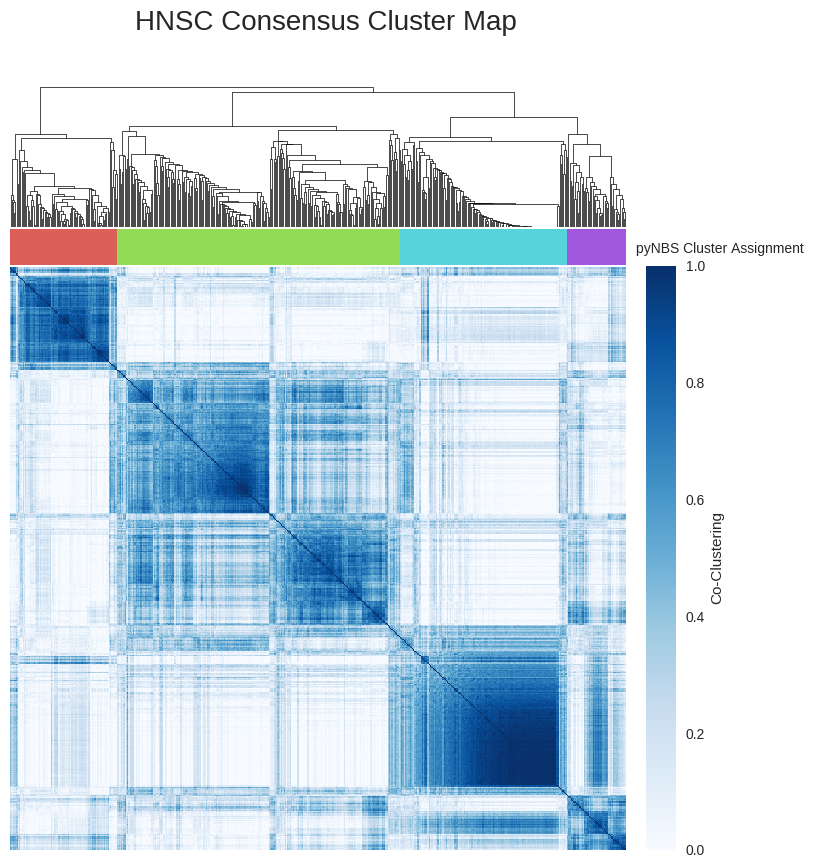

In [10]:
Image(filename = run_pyNBS_params['save_co_cluster_map'], width=600, height=600)

## Survival Plot

Multi-Class Log-Rank P: 0.141856434246


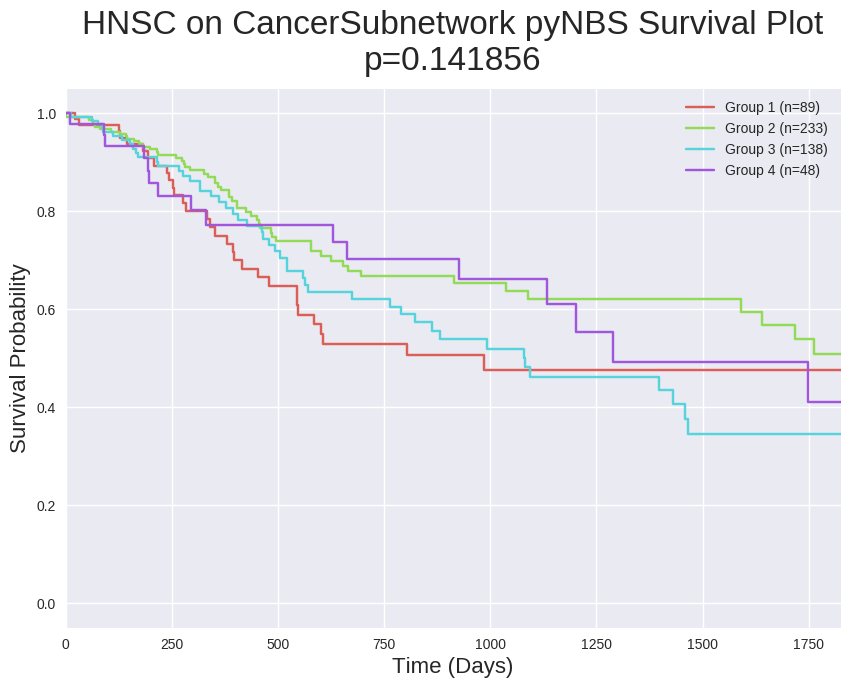

In [11]:
# Please make sure you modify file path for loading/saving to indicate your local directory
clin_path = '~/pyNBS/data/Clinical_Files/HNSC.clin.merged.surv.txt'

plot.cluster_KMplot(NBS_cluster_assign,clin_path,title='HNSC on CancerSubnetwork pyNBS Survival Plot', save_path = run_pyNBS_params['save_km_plot'])
Image(filename = run_pyNBS_params['save_km_plot'], width=600, height=600)